In [232]:
import yaml
import torch
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
import pandas as pd
from omegaconf import OmegaConf
import scanpy as sc
import seaborn as sns

import numpy as np
import IMPA.featurizer.vision_transformer as vits
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle as pkl
import sys
from matplotlib import rcParams
FIGSIZE=(3,3)               
rcParams['figure.figsize']=FIGSIZE

In [233]:
class Args(dict):
    def __init__(self, *args, **kwargs):
        super(Args, self).__init__(*args, **kwargs)
        self.__dict__ = self

**Plotting function**

In [234]:
def pca_umap_plot_with_preprocessing(adata, title, batch_name):
    sc.settings.figdir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/"

    # Set a random seed for reproducibility
    np.random.seed(0)

    # Randomly permute the indices
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    # Set a color palette for better color representation
    sns.set_palette("colorblind")

    # Plot the PCA with random reordering
    sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, s=30)

    # # Plot the UMAP with random reordering
    # sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, s=30)

    # Show the plots
    plt.show()

def initalize_stargan(config_dict, number):
    """Initialize the starGANv1 model 

    Args:
        path (str): path to the .yml configuration file for the experiment 
        number (int): number of the iteration to reload
    """
    sys.path = sys.path[:6]
    sys.path.append('/home/icb/alessandro.palma/environment/IMPA/stargan/')
    from solver_stargan import Solver as solver_stargan
    print(sys.path)
    args_stargan = Args(config_dict)
    solver = solver_stargan(args_stargan)
    solver.restore_model(number)
    return solver

**Code**

In [158]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

From https://github.com/broadinstitute/DINO4Cells_code

In [159]:
path_to_config = "/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml"
config = yaml.safe_load(open(path_to_config, "r"))
torch.cuda.is_available()

/tmp/ipykernel_2786984/703282365.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml' mode='r' encoding='UTF-8'>
  config = yaml.safe_load(open(path_to_config, "r"))


**Load model weights**

In [161]:
config["model"]["arch"] = 'vit_small'

model = vits.__dict__[config["model"]["arch"]](
                img_size=[128],
                patch_size=16,
                in_chans=5
            )

embed_dim = model.embed_dim

config["embedding"]["HEAD"] = (
        True if "HEAD" in list(config["embedding"].keys()) else False
    )

for p in model.parameters():
    p.requires_grad = False

model.eval()
model.to(device)

In [167]:
pretrained_weights = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_small_checkpoint.pth"
state_dict = torch.load(pretrained_weights)

In [169]:
if "teacher" in state_dict:
    teacher = state_dict["teacher"]
    if not config["embedding"]["HEAD"] == True:
        teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
        teacher = {
            k.replace("backbone.", ""): v for k, v in teacher.items()
        }
    msg = model.load_state_dict(teacher, strict=False)
else:
    student = state_dict
    if not config["embedding"]["HEAD"] == True:
        student = {k.replace("module.", ""): v for k, v in student.items()}
        student = {
            k.replace("backbone.", ""): v for k, v in student.items()
        }
    student = {k.replace("0.", ""): v for k, v in student.items()}
    msg = model.load_state_dict(student, strict=False)

**Featurize RxRx1 before and after batchn transformation**

In [174]:
args = {"batch_size": 8,
        "val_batch_size": 10,
        "num_workers": 6,
        "image_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1",
        "data_index_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv",
        "embedding_path": "",
        "augment_train": True,
        "normalize": True,
        "balanced": True,
        "batch_correction": True,
        "batch_key": "BATCH",
        "dim_in": 6,
        "c_dim": 3,
        "image_size": 96,
        "g_conv_dim": 64,
        "d_conv_dim": 64,
        "g_repeat_num": 6,
        "d_repeat_num": 5,
        "lambda_cls": 1,
        "lambda_rec": 10,
        "lambda_gp": 10,
        "num_iters": 300000,
        "num_iters_decay": 100000,
        "g_lr": 0.0001,
        "d_lr": 0.0001,
        "n_critic": 5,
        "beta1": 0.5,
        "beta2": 0.999,
        "resume_iters": None,
        "mode": "train",
        "use_tensorboard": False,
        "log_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/logs",
        "model_save_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/models",
        "sample_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/samples",
        "result_dir": "/lustre/groups/ml01/workspace/alessandro.palma/stargan/recursion_batch/results",
        "log_step": 500,
        "sample_step": 500,
        "model_save_step": 5000,
        "lr_update_step": 1000,
        "mol_list": None,
        "ood_set": None,
        "dataset_name": "recursion",
        "trainable_emb": True, 
        "latent_dim": 10,
        "pert_modelling": False, 
        "n_channels": False,
        "dataset_name": "rxrx1"
}

args = Args(args)

In [175]:
dataloader = CellDataLoader(args)

solver = initalize_stargan(args, 300000)
df = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/cpg0000/metadata/metadata_large_gene2vec.csv")

In [176]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

['/home/icb/alessandro.palma/IMPA/stargan', '/ictstr01/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000', '/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python39.zip', '/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9', '/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/lib-dynload', '', '/home/icb/alessandro.palma/environment/IMPA/stargan/']
Lodading the data...
Loading images...
Training with 3 mols
Successfully loaded the data
Generator(
  (main): Sequential(
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2

In [180]:
X_before_transf = []
X_after_transf = []

features = {"batch": [],
            "plate": [],
            "well": [],
            "view": [],
            "no": []}

import torch.nn.functional as F

# Transform all with the same random vector. Take the mean 
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            y = torch.zeros(X.shape[0], 3).long().cuda()
            y[:, 0] = 1
            X_generated = solver.G(X, y)
            for i, filename in enumerate(batch["file_names"]):
                batch, plate, well, view, no = filename.split("-")[1].split("_")
                features["batch"].append(batch)
                features["plate"].append(plate)
                features["well"].append(well)
                features["view"].append(view)
                features["no"].append(no)

            X = F.interpolate(X, size=(128, 128), mode='bilinear', align_corners=False)  # Resize X
            X_generated = F.interpolate(X_generated, size=(128, 128), mode='bilinear', align_corners=False)  # Resize X_generated           
            Z_before_transf = model(X[:, :-1, :, :])
            Z_after_transf = model(X_generated[:, :-1, :, :])
            # Z_before_transf = model(X)
            # Z_after_transf = model(X_generated)

            X_before_transf.append(Z_before_transf.detach().cpu())
            X_after_transf.append(Z_after_transf.detach().cpu())

100%|██████████| 3427/3427 [01:36<00:00, 35.39it/s]


In [181]:
X_before_transf = torch.cat(X_before_transf, dim=0)
X_after_transf = torch.cat(X_after_transf, dim=0)

In [182]:
X_before_transf

tensor([[ 0.9218,  0.2746, -0.7908,  ...,  0.4712, -0.2485,  0.7664],
        [ 0.8160,  0.9125, -0.9264,  ...,  1.8490, -0.0070,  2.3318],
        [ 0.5862, -0.5364,  1.5237,  ...,  2.1465, -1.3804,  1.6503],
        ...,
        [ 2.7620,  1.7222, -2.6412,  ..., -0.3955, -0.5331,  0.5119],
        [-0.7441,  3.4734, -3.0333,  ...,  0.5722, -0.3190, -1.0232],
        [-1.3652,  2.4301, -3.9698,  ..., -0.4326,  0.4137, -2.8076]])

In [183]:
adata_before_transf = sc.AnnData(X=X_before_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))
adata_after_transf = sc.AnnData(X=X_after_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Before correction

In [184]:
sc.tl.pca(adata_before_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/an

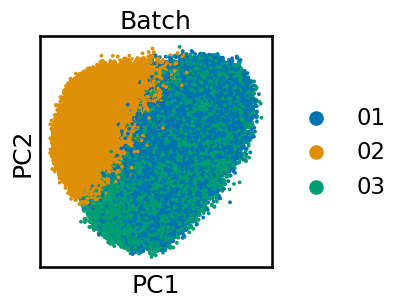

In [185]:
pca_umap_plot_with_preprocessing(adata_before_transf, "Batch", "batch")

After correction

In [186]:
adata_after_transf

AnnData object with n_obs × n_vars = 170943 × 384
    obs: 'batch', 'plate', 'well', 'view', 'no'

In [187]:
sc.tl.pca(adata_after_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/an

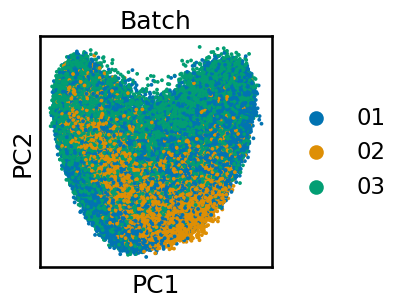

In [188]:
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "batch")

## Save results

In [189]:
feature_dest_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1")

In [190]:
# adata_after_transf = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_after_transf_stargan.h5ad")

In [191]:
# adata_before_transf = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [192]:
# adata_before_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [242]:
# adata_after_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_after_transf_stargan.h5ad")

In [194]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)

In [195]:
compound_names = []

for row in adata_before_transf.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)

In [196]:
adata_before_transf.obs["compound"] = compound_names

In [197]:
adata_after_transf.obs["compound"] = compound_names

## Evaluate scib metrics

In [198]:
from scib_metrics.benchmark import Benchmarker
from scib_metrics.benchmark import BioConservation, BatchCorrection
import scib

In [199]:
adata_unique = adata_before_transf.copy()

In [200]:
biocons = BioConservation(isolated_labels=False, 
                              nmi_ari_cluster_labels_leiden=False, 
                              nmi_ari_cluster_labels_kmeans=False,
                              silhouette_label=True,
                              clisi_knn=False)
    
batch_correction = BatchCorrection(silhouette_batch=True,
                                    ilisi_knn=False, 
                                    kbet_per_label=False, 
                                    graph_connectivity=False, 
                                    pcr_comparison=False)

In [201]:
adata_unique.obsm["Unintegrated"] = adata_before_transf.obsm["X_pca"].copy()

In [202]:
adata_unique.obsm["IMPA-Integrated"] = adata_after_transf.obsm["X_pca"].copy()

In [203]:
# adata_unique.obsm["scPoli-Integrated"] = adata_scpoli.X.copy()

In [204]:
# adata_unique.obsm["scGen-Integrated"] = adata_scgen.X.copy()

In [205]:
# adata_unique.obsm["harmony-Integrated"] = adata_before_transf.obsm['X_emb'].copy()

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


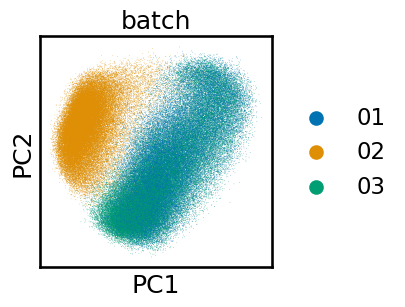

In [206]:
sc.pl.pca(adata_before_transf, color="batch")

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


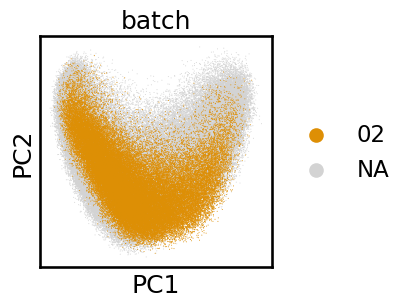

In [207]:
sc.pl.pca(adata_after_transf, color="batch", groups="02", size=2)

In [208]:
from scib_metrics.benchmark import Benchmarker

In [ ]:
bm = Benchmarker(
    adata_unique,
    batch_key="batch",
    label_key="compound",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=batch_correction,
    embedding_obsm_keys=["Unintegrated", "IMPA-Integrated"],
    n_jobs=6
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                            
Metrics:  10%|█         | 1/10 [09:37<1:26:29, 576.60s/it, Batch correction: silhouette_batch]

In [227]:
scib_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/scib/rxrx1_stargan.pkl"

In [228]:
# with open(scib_path, "wb") as file:
#     pkl.dump(bm, file)

In [24]:
# with open(scib_path, "rb") as file:
#     b = pkl.load(file)

**Plot scib metrics**

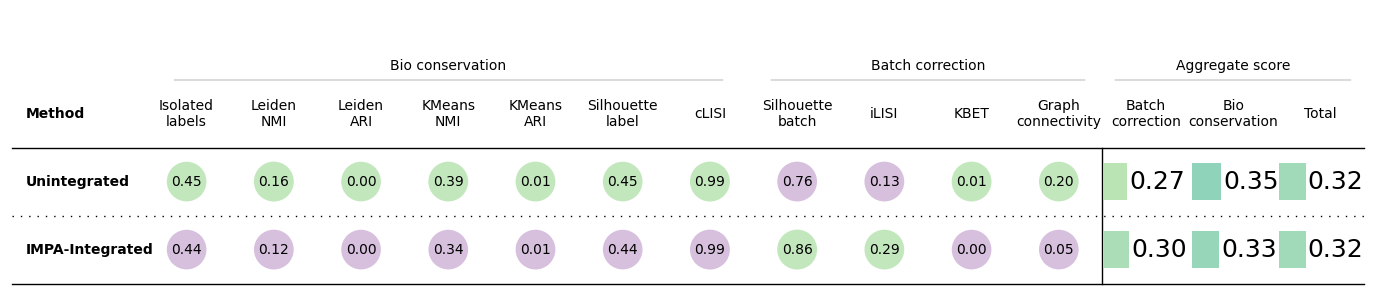

In [235]:
bm.plot_results_table(min_max_scale=False)

In [2]:
print((0.86+0.13+0.88+0.30+0.35)/3)
print((0.88+0.29+1.18+0.50+0.40)/3)

0.84
1.0833333333333333


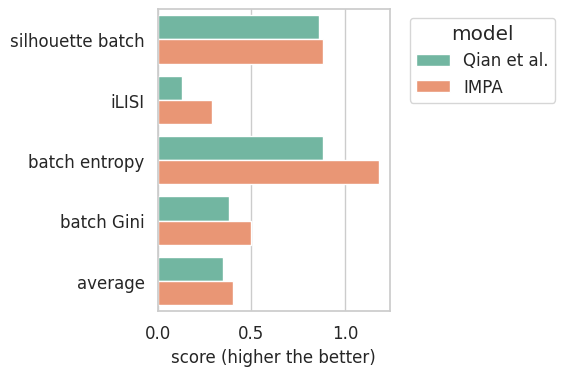

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'model': ['Qian et al.', 'IMPA'],
    'silhouette batch': [0.86, 0.88], 
    'iLISI': [0.13, 0.29],
    'batch entropy': [0.88, 1.18],
    'batch Gini': [0.38, 0.50], 
    'average': [0.35, 0.40] 
    }


# Convert data to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to plot with Seaborn
df_melted = pd.melt(df, id_vars=['model'], var_name='Metric', value_name='Score')

# Set aesthetic parameters
sns.set(style='whitegrid', font_scale=1.2)

# Plotting with Seaborn - Horizontal Point plot (Swarm plot)
plt.figure(figsize=(6, 4))
palette = sns.color_palette("Set2")  # Choose a suitable color palette
# sns.stripplot(data=df_melted, y='Metric', x='Score', hue='model', palette=palette, dodge=False, jitter=True, size=14)  # Increase size here
sns.barplot(data=df_melted, y='Metric', x='Score', hue='model', palette=palette)  # Increase size here
plt.title('', fontsize=12)
plt.xlabel('score (higher the better)', fontsize=12)
plt.ylabel('', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Place legend outside the plot
plt.legend(title='model', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/plots/scib_metrics_stargan.svg',
           dpi=300, bbox_inches='tight', format='svg')
plt.show()



In [6]:
(1.0833333333333333-0.84)/0.84

0.28968253968253965